## MTH9893 Time Series Analysis HW3
* Group 01
* Author: Pan, Hongchao & Sun, Yu
* Kernel version: Python 3.5
* Packages: pandas, matplotlib,statsmodels, time
* Data: 
    * Data were stored in the folder **datasets**
    * Q2: PX_LAST of SPX and VIX over last 5 years
    * Q3(optional question): PX_LAST of CL1 Comdty and CVX (Shevron) 
* Notes: 
    * The running time of this notebook is around 3s
    * The original **SPX index is not stationary, but the 1st order differential of SPX index is stationary**. Thereby test the Granger Causality between VIX and 1st order differential of SPX
    * The VIX index **does have Granger Causality** on SPX index, but SPX index does not have Granger Causality on VIX index.
    <br><br>
    * The CL1 Comdty and CVX data are not stationary, but the 1st order differential of them are stationary, which is consistent with intuition.
    * **the SPX does not have Granger-causality on VIX, and the VIX does not have Granger-causality on SPX neither.**

## Question 2

In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.vector_ar.var_model as var_model  # For VAR(p)
import statsmodels.tsa.stattools as statools
import statsmodels.tsa.stattools as tsa  # adfuller test
import time

In [2]:
# Record the running time of the notebook
startTALL=time.time()

In [3]:
# Define a function to get the data
def get_data():
    # Retrive the historical daily end of the day (PX_LAST)
    # of SPX and VIX over the last 5 years from folder 'datasets'
    
    # Get the data of SPX
    df_spx=pd.read_excel(io='datasets/SPX_Daily.xlsx',sheetname=0,parse_cols='A:B',skiprows=1)
    # Get the data of VIX
    df_vix=pd.read_excel(io='datasets/VIX_Daily.xlsx',sheetname=0,parse_cols='A:B',skiprows=1)
    
    # Both data has been sorted by the date from oldest to latest and has same length
    
    # Rename the columns of both dataframe
    df_spx.columns=['Date','SPX PX_LAST']
    df_vix.columns=['Date','VIX PX_LAST']
    # Combine the two dataframe
    df=df_spx.merge(df_vix,on='Date',how='inner')
    
    return df

In [4]:
df_Q2=get_data()

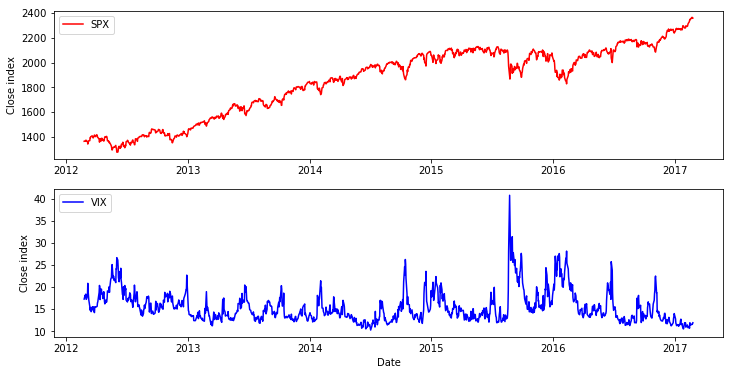

In [5]:
# Plot the data in 1 figure
plt.figure(1,figsize=(12,6)) # Change figure size
# Plot SPX index
plt.subplot(211)
plt.plot(df_Q2['Date'],df_Q2['SPX PX_LAST'],'r-')
plt.ylabel('Close index')
plt.legend(['SPX'],loc='upper left')

# Plot VIX index
plt.subplot(212)
plt.plot(df_Q2['Date'],df_Q2['VIX PX_LAST'],'b-')
plt.xlabel('Date')
plt.ylabel('Close index')
plt.legend(['VIX'],loc='upper left')
plt.show()

Figure 1 The overview of SPX and VIX close index over past 5 years
* **Observations**:
    * Figure 1 shows that VIX index jupms up when SPX index drops over the past 5 years
    * SPX index has a increasing trend  indicates that it is ** not stationary** over past 5 years, but VIX index looks more stable indicates that it is **stationary** over past 5 years. Thereby, further stationary test needs to be applied.

### Stationary test
Define a test funtion to test whether a time series is stationary with **confidence interval 95%**

In [6]:
def stationary_test(TsData,CI):
    # TsData: to be tested time series data
    # CI: the critical value for test statistic, string of 1%, 5%, or 10%
    res=tsa.adfuller(TsData)
    
    # reference: https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test
    if(res[0]>res[4][CI]):
        return (res[0],res[4][CI],'non-stationary')
    else:
        return (res[0],res[4][CI],'stationary')


In [7]:
# Test the stationary of SPX index and VIX index 
sta_SPX=stationary_test(df_Q2['SPX PX_LAST'],'5%')
sta_VIX=stationary_test(df_Q2['VIX PX_LAST'],'5%')
sta_df=pd.DataFrame({'SPX':list(sta_SPX),'VIX':list(sta_VIX)},
                   index=['adf(test statistic)','CI value','stationary/non-stationary'])
sta_df

,SPX,VIX
adf(test statistic),-0.860425,-6.87366
CI value,-2.86384,-2.86384
stationary/non-stationary,non-stationary,stationary


Table 1 Stationary test of SPX index and VIX index over past 5 years

### Change SPX index to stationary

Since stationary of two time series is required for Granger Causality test, we need make the SPX index to stationary.

**Try differential method**

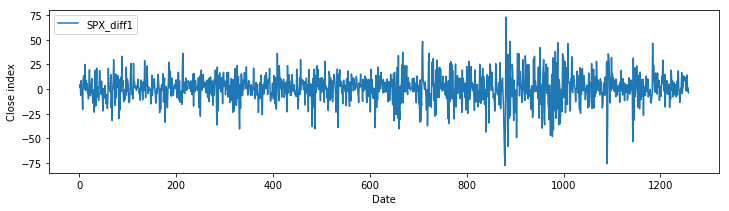

In [8]:
# Take the 1st-order difference of SPX index data
df_Q2['SPX_diff1']=df_Q2['SPX PX_LAST'].diff()  # The 1st row of 'SPX_diff1' will be NaN
plt.figure(1,figsize=(12,3)) # Change figure size
plt.plot(df_Q2.iloc[1:]['SPX_diff1'])  # Avoid NaN in 1st row
plt.xlabel('Date')
plt.ylabel('Close index')
plt.legend(['SPX_diff1'],loc='upper left')
plt.show()

Figure 2 SPX close index with 1st order difference over past 5 years. Clearly, the 1st order differential data should be stationary.

* Stationary test of 1st order differential data of SPX index

In [9]:
# Stationary test of 1st order differential data of SPX index
tsa_SPX_diff=stationary_test(df_Q2.iloc[1:]['SPX_diff1'],'5%') # Avoid 1st row (NaN)
sta_df['SPX_diff1']=list(tsa_SPX_diff)  # Append result to the new column of stationary test result
sta_df

,SPX,VIX,SPX_diff1
adf(test statistic),-0.860425,-6.87366,-19.4979
CI value,-2.86384,-2.86384,-2.86385
stationary/non-stationary,non-stationary,stationary,stationary


Table 2 Stationary test of SPX index, VIX index, and 1st order differential of SPX index over past 5 years

* Notes: Since the differential of SPX index has the information of SPX index and is stationary, we should use SPX_diff1 to test Granger Causality with VIX index

### Test the Granger Causality between VIX and SPX (SPX_diff1)

* Calculate the lag of time series $X$=matrix(SPX_diff1,VIX) with VAR model

In [10]:
# Change index of df_Q2 to the date object for VAR model
df_Q2.set_index('Date',inplace=True)
# Erase the row has NaN data and the column of 'SPX PX_LAST'
df_gc=df_Q2.iloc[1:][['VIX PX_LAST','SPX_diff1']]
df_gc.head()

,VIX PX_LAST,SPX_diff1
Date,,
2012-02-27,18.19,1.85
2012-02-28,17.96,4.59
2012-02-29,18.43,-6.50
2012-03-01,17.26,8.41
2012-03-02,17.29,-4.46


Table 3 Overview of SPX and VIX dataframe

In [11]:
# VAR model
# Reference: http://statsmodels.sourceforge.net/devel/vector_ar.html
VAR_model2=var_model.VAR(df_gc)
# Select the lag
# Since the running time of the select_order function of VAR model, set the maxlags=30
res=VAR_model2.select_order(maxlags=30)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0         7.871        7.880        2621.        7.874
1         4.736        4.761        114.0        4.745
2         4.708       4.750*        110.9       4.724*
3        4.707*        4.766       110.8*        4.729
4         4.708        4.783        110.8        4.736
5         4.709        4.801        111.0        4.744
6         4.714        4.822        111.4        4.754
7         4.716        4.841        111.7        4.763
8         4.718        4.859        111.9        4.771
9         4.719        4.877        112.0        4.778
10        4.719        4.894        112.0        4.785
11        4.723        4.915        112.6        4.796
12        4.728        4.936        113.0        4.806
13        4.730        4.955        113.3        4.814
14        4.736        4.977        113.9        4.827
15        

Table 4 Result of VAR(p) order selection: best model is **VAR(3)** based on AIC and **VAR(2)** based on BIC

In [12]:
# Fit the model based on the results above from select_order function
# Fit the model with desired lag, i.e., set the maxlags=3, ic='aic'
model_res=VAR_model2.fit(maxlags=3,method='ols',ic='aic',verbose=False)
model_res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 28, Feb, 2017
Time:                     11:31:37
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    4.75074
Nobs:                     1255.00    HQIC:                   4.71499
Log likelihood:          -6492.68    FPE:                    109.230
AIC:                      4.69346    Det(Omega_mle):         108.022
--------------------------------------------------------------------
Results for equation VIX PX_LAST
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  1.082261         0.183868            5.886           0.000
L1.VIX PX_LAST         0.995805         0.052465           18.980           0.000
L1.SPX_diff1           0.005975         0.004664  

Table 5 Summary results of VAR model fit with maxlags=3

#### Granger Causality test of VIX on SPX (SPX_diff1)

In [13]:
# Granger Causality test
# Reference: http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.vector_ar.var_model.VARResults.test_causality.html
# kind 'f': F-test
# confidence interval: 95%
# Test whether 2nd variable has Granger Causality on 1st variable, i.e., test VIX on SPX_diff1
# Notes: the sequence/order of variables are matter!
gctest=model_res.test_causality('SPX_diff1','VIX PX_LAST',kind='f',signif=0.05)

Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
        10.165602         2.608468            0.000  (3, 2496)
H_0: ['VIX PX_LAST'] do not Granger-cause SPX_diff1
Conclusion: reject H_0 at 5.00% significance level


Table 6 The Granger Causality test of VIX index on SPX_diff1 index based on VAR(3) model

The results in table 6 shows that VIX index **does have Granger Causality** on SPX_diff1, which indicates that the VIX index **does have Granger Causality** on SPX index

#### Granger Causality test of SPX index (SPX_diff1) on VIX index

In [14]:
# Granger Causality test
# Reference: http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.vector_ar.var_model.VARResults.test_causality.html
# kind 'f': F-test
# confidence interval: 95%
# Test whether 2nd variable has Granger Causality on 1st variable, i.e. test SPX_diff1 on VIX
# Notes: the sequence/order of variables are matter!
gctest2=model_res.test_causality('VIX PX_LAST','SPX_diff1',kind='f',signif=0.05)

Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
         0.853802         2.608468            0.464  (3, 2496)
H_0: ['SPX_diff1'] do not Granger-cause VIX PX_LAST
Conclusion: fail to reject H_0 at 5.00% significance level


Table 7 The Granger Causality test of VIX index on SPX index based on VAR(3) model

The results in table 7 shows that SPX_diff1 **does not have Granger Causality** on VIX index, which indicates that the SPX index **does not have Granger Causality** on VIX index

### Answers/Observations of Q2

* The original **SPX index is not stationary, but the 1st order differential of SPX index is stationary**. And stationary of two time series is required of Granger Causality test, thereby we tested Granger Causality between 1st order differential data of SPX and VIX.
<br><br>

* The best fitted VAR(p) model of SPX_diff1 and VIX is p=3 based on AIC and fpe and p=2 based on BIC and hqic.
<br><br>

* From the Granger Causality test results, SPX and the SPX does not have Granger-causality on VIX, but **the VIX does have Granger-causality on SPX.**

<br><br>

## Question 3
* Optional question: Test the Granger Causality between CL1 Comdty and CVX over past 5 years

In [15]:
# Define a function to get the data
def get_data3():
    # Retrive the historical daily end of the day price (PX_LAST)
    # of CL1 and CVX over the last 5 years from folder 'datasets'
    
    # Get the data of CL1 Comdty
    df_CL1=pd.read_excel(io='datasets/CL1_Daily.xlsx',sheetname=0,parse_cols='A:B',skiprows=1)
    # Get the data of CVX
    df_CVX=pd.read_excel(io='datasets/CVX_Daily.xlsx',sheetname=0,parse_cols='A:B',skiprows=1)
    
    # Both data has been sorted by the date from oldest to latest and has same length
    
    # Rename the columns of both dataframe
    df_CL1.columns=['Date','CL1 PX_LAST']
    df_CVX.columns=['Date','CVX PX_LAST']
    # Combine the two dataframe
    df=df_CL1.merge(df_CVX,on='Date',how='inner')
    
    return df

In [16]:
df_Q3=get_data3()

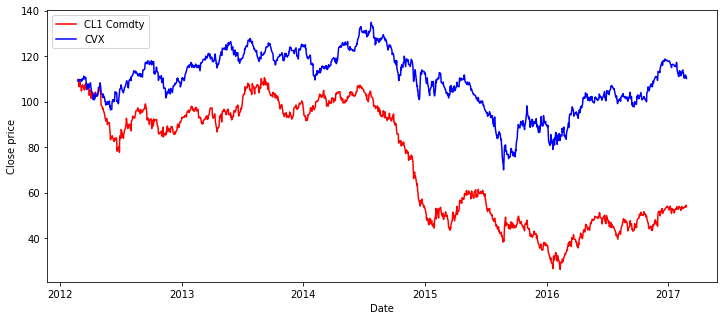

In [17]:
# Plot the data in 1 figure
plt.figure(3,figsize=(12,5)) # Change figure size
# Plot CL1 and CVX
plt.plot(df_Q3['Date'],df_Q3['CL1 PX_LAST'],'r-',
        df_Q3['Date'],df_Q3['CVX PX_LAST'],'b-')
plt.xlabel('Date')
plt.ylabel('Close price')
plt.legend(['CL1 Comdty','CVX'],loc='upper left')
plt.show()

Figure 3 The overview of CL1 Comdty and CVX close price over past 5 years
* **Observations**:
    * Figure 3 shows the positive correlation of CL1 Comdty and CVX over the past 5 years
    * Both curves shows trend over the past 5 years, which indicates the time series of them are **not stationary**. Thereby, further stationary test needs to be applied.

### Stationary test

In [18]:
# Test the stationary of SPX index and VIX index 
sta_CL1=stationary_test(df_Q3['CL1 PX_LAST'],'5%')
sta_CVX=stationary_test(df_Q3['CVX PX_LAST'],'5%')
sta_df3=pd.DataFrame({'CL1':list(sta_CL1),'CVX':list(sta_CVX)},
                   index=['adf(test statistic)','CI value','stationary/non-stationary'])
sta_df3

,CL1,CVX
adf(test statistic),-1.19343,-1.84755
CI value,-2.86384,-2.86384
stationary/non-stationary,non-stationary,non-stationary


Table 8 Stationary test of CL1 Comdty and CVX over past 5 years

### Change time series to stationary

Since stationary of two time series is required for Granger Causality test, we need make both of them to be stationary.

**Try differential method**

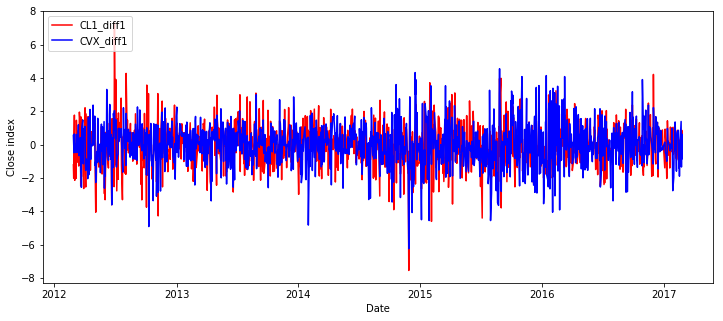

In [19]:
# Take the 1st-order difference of CL1 Comdty and CVX
df_Q3['CL1_diff1']=df_Q3['CL1 PX_LAST'].diff()  # The 1st row of 'CL1_diff1' will be NaN
df_Q3['CVX_diff1']=df_Q3['CVX PX_LAST'].diff()  # The 1st row of 'CVX_diff1' will be NaN
plt.figure(4,figsize=(12,5)) # Change figure size
plt.plot(df_Q3.iloc[1:]['Date'],df_Q3.iloc[1:]['CL1_diff1'],'r-',
        df_Q3.iloc[1:]['Date'],df_Q3.iloc[1:]['CVX_diff1'],'b-')  # Avoid NaN in 1st row
plt.xlabel('Date')
plt.ylabel('Close index')
plt.legend(['CL1_diff1','CVX_diff1'],loc='upper left')
plt.show()

Figure 4 CL1 Comdty and CVX with 1st order difference over past 5 years. Clearly, the 1st order differential data should be stationary. This is consistent with the intuition that the daily returns of most stocks in short-term are stationary

* Stationary test of the 1st order differential data

In [20]:
# Stationary test of 1st order differential data of SPX index
tsa_CL1_diff=stationary_test(df_Q3.iloc[1:]['CL1_diff1'],'5%') # Avoid 1st row (NaN)
tsa_CVX_diff=stationary_test(df_Q3.iloc[1:]['CVX_diff1'],'5%') # Avoid 1st row (NaN)
sta_df3['CL1_diff1']=list(tsa_CL1_diff)  # Append result to the new column of stationary test result
sta_df3['CVX_diff1']=list(tsa_CVX_diff)  # Append result to the new column of stationary test result
sta_df3


,CL1,CVX,CL1_diff1,CVX_diff1
adf(test statistic),-1.19343,-1.84755,-38.9427,-18.8835
CI value,-2.86384,-2.86384,-2.86384,-2.86385
stationary/non-stationary,non-stationary,non-stationary,stationary,stationary


Table 9 Stationary test of CL1 Comdty, CVX, and 1st order differential data of them over past 5 years

* Notes: Since the differential has the information of stock itself and is stationary, we should use CL1_diff1 and CVX_diff1 to test Granger Causality.

### Test the Granger Causality between CL1_diff1 and CVX_diff1

* Calculate the lag of time series $X$=matrix(CL1_diff1,CVX_diff1) with VAR model

In [21]:
# Change index of df_Q3 to the date object for VAR model
df_Q3.set_index('Date',inplace=True)
# Erase the row has NaN data and the column of 'SPX PX_LAST'
df_gc3=df_Q3.iloc[1:][['CL1_diff1','CVX_diff1']]
df_gc3.head()

,CL1_diff1,CVX_diff1
Date,,
2012-02-27,-1.21,0.55
2012-02-28,-2.01,-0.02
2012-02-29,0.52,-0.49
2012-03-01,1.77,0.64
2012-03-02,-2.14,-0.15


Table 10 Overview of CL1_diff1 and CVX_diff1 dataframe

In [22]:
# VAR model
# Reference: http://statsmodels.sourceforge.net/devel/vector_ar.html
VAR_model3=var_model.VAR(df_gc3)
# Select the lag
# Since the running time of the select_order function of VAR model, set the maxlags=30
res3=VAR_model3.select_order(maxlags=30)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        0.7353      0.7436*        2.086      0.7384*
1        0.7323       0.7573        2.080       0.7417
2       0.7315*       0.7731       2.078*       0.7471
3        0.7344       0.7927        2.084       0.7564
4        0.7370       0.8120        2.090       0.7652
5        0.7430       0.8346        2.102       0.7775
6        0.7457       0.8539        2.108       0.7864
7        0.7487       0.8737        2.114       0.7957
8        0.7541       0.8957        2.126       0.8074
9        0.7558       0.9140        2.129       0.8154
10       0.7581       0.9329        2.134       0.8239
11       0.7611       0.9526        2.141       0.8331
12       0.7672       0.9754        2.154       0.8455
13       0.7732       0.9981        2.167       0.8578
14       0.7794        1.021        2.180       0.8702
15       0

Table 11 Result of VAR(p) order selection: best model is **VAR(2)** based on AIC and **VAR(0)** based on BIC

In [23]:
# Fit the model based on the results above from select_order function
# Fit the model with desired lag, i.e., set the maxlags=2, ic='aic'
model_res3=VAR_model3.fit(maxlags=2,method='ols',ic='aic',verbose=False)
model_res3.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 28, Feb, 2017
Time:                     11:31:39
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.759352
Nobs:                     1257.00    HQIC:                  0.744049
Log likelihood:          -4023.05    FPE:                    2.08514
AIC:                     0.734834    Det(Omega_mle):         2.07522
--------------------------------------------------------------------
Results for equation CL1_diff1
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               -0.048453         0.036123           -1.341           0.180
L1.CL1_diff1        -0.113213         0.032609           -3.472           0.001
L1.CVX_diff1         0.037066         0.032080            1.

Table 12 Summary results of VAR model fit with maxlags=2

#### Granger Causality test of CL1_diff on CVX_diff1

In [24]:
# Granger Causality test
# Reference: http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.vector_ar.var_model.VARResults.test_causality.html
# kind 'f': F-test
# confidence interval: 95%
# Test whether 2nd variable has Granger Causality on 1st variable, i.e., test CVX_diff1 on CL1_diff1
# Notes: the sequence/order of variables are matter!
gctest_q3=model_res3.test_causality('CL1_diff1','CVX_diff1',kind='f',signif=0.05)

Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
         1.335020         3.845169            0.248  (1, 2508)
H_0: ['CVX_diff1'] do not Granger-cause CL1_diff1
Conclusion: fail to reject H_0 at 5.00% significance level


Table 13 The Granger Causality test of CVX_diff1 on CL1_diff1 based on VAR(2) model

The results in table 13 shows that CVX_diff1 **does not have Granger Causality** on CL1_diff1, which indicates that the CVX **does not have Granger Causality** on CL1 Comdty

#### Granger Causality test of CL1 (CL1_diff1) on CVX (CVX_diff1)

In [25]:
# Granger Causality test
# Reference: http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.vector_ar.var_model.VARResults.test_causality.html
# kind 'f': F-test
# confidence interval: 95%
# Test whether 2nd variable has Granger Causality on 1st variable, i.e., test CL1_diff1 on CVX_diff1
# Notes: the sequence/order of variables are matter!
gctest3_q3=model_res3.test_causality('CVX_diff1','CL1_diff1',kind='f',signif=0.05)

Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
         1.271581         3.845169            0.260  (1, 2508)
H_0: ['CL1_diff1'] do not Granger-cause CVX_diff1
Conclusion: fail to reject H_0 at 5.00% significance level


Table 14 The Granger Causality test of CL1_diff1 on CVX_diff1 based on VAR(2) model

The results in table 14 shows that CL1_diff1 **does not have Granger Causality** on CVX_diff1, which indicates that the CL1 Comdty **does not have Granger Causality** on CVX

### Answers/Observations of Q3

* The original **CL1 Comdty and CVX are not stationary, but the 1st order differential of them are stationary**. This is consistent with the intuition that the daily returns of most stocks in short-term are stationary.
<br><br>

* As stationary of two time series is required of Granger Causality test, thereby we tested Granger Causality between 1st order differential data of CL1 Comdty and CVX.
<br><br>

* The best fitted VAR(p) model of SPX_diff1 and VIX is p=2 based on AIC and fpe.
<br><br>

* From the Granger Causality test results, **the SPX does not have Granger-causality on VIX, and the VIX does not have Granger-causality on SPX neither.**

In [26]:
# Stop recording running time
endTALL=time.time()
print('Running time of notebook: %.2f seconds' %(endTALL-startTALL))

Running time of notebook: 3.29 seconds
